In [3]:
import numpy as np
from numpy.linalg import solve
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy import optimize
from scipy.special import erfinv
from scipy.optimize import minimize_scalar
import egrss 
import time
from ipynb.fs.full.functions_lambda import smoothing_spline_reg, GML

<ipython-input-7-c10e4f5c97cc>:31: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(np.log(np.transpose(yhat) @ alpha) + 2/(N-p)* np.sum(np.log(z)) + 2/(N-p) *np.log(abs(np.linalg.det(R))))
<ipython-input-7-c10e4f5c97cc>:79: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(-res_GML.x, res_GML.fun, 'bo', color = 'navy', label = '$\lambda_{GML}^{*}=1.192e-7$')
<ipython-input-7-c10e4f5c97cc>:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x,yhat,'bo',markersize = 4.5, color = 'cornflowerblue')


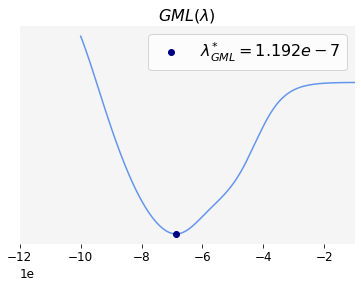

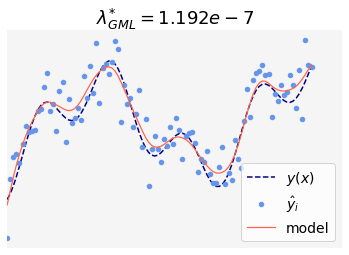

In [7]:
def smoothing_spline_reg(Ut,Wt,z,yhat,obj = 'nothing'):
    p,n = Ut.shape
    B   = np.zeros((n,p))
    for k in range(p):
        B[:,k] = egrss.trsv(Ut,Wt,Ut[k,:].T, z,'N') 
    Q, R     = qr(B)
    c        = egrss.trsv(Ut,Wt,yhat,z,'N')
    c        = np.dot(Q.T,c)
    d        = solve(R[0:p,0:p],c[0:p])
    c[0:p]   = 0
    c        = egrss.trsv(Ut,Wt,np.dot(Q,c), z,'T')
    if obj == 'nothing':
        return c, d
    elif obj == 'gml': 
        log_glm  = np.log(np.dot(yhat.T,c)) + 2.0 / (n-p ) * (np.sum(np.log(z),axis = 0) + np.sum( np.log(np.abs(np.diag(R[0:p,0:p])))))
        return c, d, log_glm
    else:
        raise Exception("Unknown objective")
        
# Generalized maximum likelihood
def GML(q):
    lam = 1/np.power(10,q)
    Ut, Vt = egrss.generators((x-a)/(b-a),p)
    Wt, z  = egrss.potrf(Ut,Vt,N*lam/xi)
    LinvF = np.zeros([N,p])
    for i in range(p):
        LinvF[:,i] = egrss.trsv(Ut,Wt,Ut[i,:],z,'N') 
    q,R = np.linalg.qr(LinvF)

    alpha ,d  = smoothing_spline_reg(Ut,Wt,z,yhat) 
    return np.asscalar(np.log(np.transpose(yhat) @ alpha) + 2/(N-p)* np.sum(np.log(z)) + 2/(N-p) *np.log(abs(np.linalg.det(R))))

def GCV(q):
    """
    Generalized cross validation
    """
    lam = 1/np.power(10,q)
    Ut, Vt = egrss.generators((x-a)/(b-a),p) 
    Wt, z  = egrss.potrf(Ut,Vt,N*lam/xi)
    alpha ,d  = smoothing_spline_reg(Ut,Wt,z,yhat) 
    Linv = egrss.trtri2(Ut,Wt,z)
    LinvF = np.zeros([N,p])
    for i in range(p):
        LinvF[:,i] = egrss.trsv(Ut,Wt,Ut[i,:], z,'N') 
    Q,R = np.linalg.qr(LinvF, mode = 'reduced')

    LinvTQ = np.zeros([N,p])
    for k in range(p):
        LinvTQ[:,k] = egrss.trsv(Ut,Wt,Q[:,k],c=z,trans='T')

    return np.asscalar(np.log(N) + 2*np.log(np.linalg.norm(alpha))- 2*np.log(np.linalg.norm(Linv,'fro')**2 - np.linalg.norm(LinvTQ,'fro')**2))

# Generate data with noise level sigma
N = 100
sigma = 0.1
a, b = -0.2, 0.5
p = 2  # degree of splines
xi = (b-a) ** (2 * p - 1)
xx = np.linspace(a,b,N)

x = np.linspace(a,b,N)

# Function 
def y(x):
    return 0.25*np.cos(4*np.pi *x) + 0.15*np.sin(12* np.pi *x) + 0.2 * x

yhat = y(x) + sigma * np.random.normal(loc = 0, scale = 1, size = x.shape)

# Finding the optimal lambda - GML
res_GML = minimize_scalar(GML, bounds = (0,10), method='bounded')

# Plot with optimal lambda value
fig1 = plt.figure()
q = np.linspace(0,10,200)
GML_res = np.zeros(200)
for i in range(0,len(q)):
    GML_res[i] = GML(q[i])
plt.plot(-q,GML_res, color = 'cornflowerblue')
plt.plot(-res_GML.x, res_GML.fun, 'bo', color = 'navy', label = '$\lambda_{GML}^{*}=1.192e-7$')
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.xlabel('1e', loc = 'left', fontsize = 12)
plt.xlim([-12,-1])
plt.yticks(GML_res, "")
plt.xticks(fontsize = 12)
plt.title('$GML(\lambda)$', fontsize = 16)
plt.tick_params(left=False, bottom = True, right = False, top = False)
ax = plt.gca()
ax.set_facecolor('whitesmoke')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend( loc='upper right', numpoints=1, prop={'size': 16} )
plt.show


# fig1.savefig("GMLlambda.pdf", bbox_inches='tight')

# Plotting the model generated with lambda_GML
fig2 = plt.figure()
lam = 1/np.power(10,res_GML.x)
x = np.linspace(a,b,N)
Ut, Vt = egrss.generators((x-a)/(b-a),p)
Wt, z  = egrss.potrf(Ut,Vt,N*lam/xi)
c,d    = smoothing_spline_reg(Ut,Wt,z,yhat)
plt.plot(xx,y(xx),'--',color = 'navy', linewidth=1.5)
plt.plot(x,yhat,'bo',markersize = 4.5, color = 'cornflowerblue')
plt.plot(x,yhat-N*lam/xi*c,color = 'tomato', linewidth=1.2)
plt.xticks([])
plt.yticks([])
plt.xlim([a,b+0.07])
plt.tick_params(left=False, bottom = False, right = False, top = False)
plt.legend(['$y(x)$', '$\hat{y}_i$', 'model'], numpoints = 1, prop = {'size': 14}, loc = 'lower right')
ax = plt.gca()
ax.set_facecolor('whitesmoke')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.title('$\lambda_{GML}^{*}=1.192e-7$', fontsize = 18)
plt.show()
# fig2.savefig("GMLmodel.pdf", bbox_inches='tight')

<ipython-input-2-3e945583a9d0>:62: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(np.log(N) + 2*np.log(np.linalg.norm(alpha))- 2*np.log(np.linalg.norm(Linv,'fro')**2 - np.linalg.norm(LinvTQ,'fro')**2))
<ipython-input-3-166dae22335d>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(-res_GCV.x, res_GCV.fun, 'bo', color = 'navy', label = '$\lambda_{GCV}^{*}=9.118e-6$')
<ipython-input-3-166dae22335d>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x,yhat,'bo',markersize = 4.5, color = 'cornflowerblue')


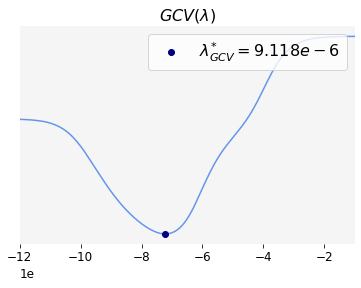

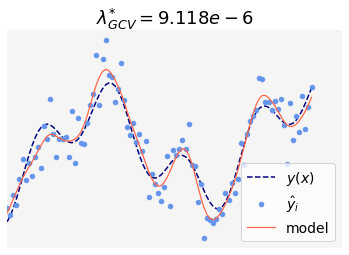

In [3]:
# Generelized cross validation
res_GCV = minimize_scalar(GCV, bounds = (0,13), method='bounded')

# plotting GCV(lambda)
fig3 = plt.figure()
q = np.linspace(0,13,200)
GCV_res = np.zeros(200)
for i in range(0,len(q)):
    GCV_res[i] = GCV(q[i])
plt.plot(-q,GCV_res, color = 'cornflowerblue')
plt.plot(-res_GCV.x, res_GCV.fun, 'bo', color = 'navy', label = '$\lambda_{GCV}^{*}=9.118e-6$')
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.xlabel('1e', loc = 'left', fontsize = 12)
plt.xlim([-12,-1])
plt.yticks(GCV_res, "")
plt.xticks(fontsize = 12)
plt.title('$GCV(\lambda)$', fontsize = 16)
plt.tick_params(left=False, bottom = True, right = False, top = False)
ax = plt.gca()
ax.set_facecolor('whitesmoke')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend( loc='upper right', numpoints=1, prop={'size': 16} )
plt.show
fig3.savefig("GCVlambda.pdf", bbox_inches='tight')


# Plotting the model generated with lambda_GCV
fig4 = plt.figure()
a,b   = -0.2, 0.5
p = 2
xi     = (b-a) ** (2 * p - 1) 
lam = 1/np.power(10,res_GCV.x)
x = np.linspace(a,b,N)
Ut, Vt = egrss.generators((x-a)/(b-a),p)
Wt, z  = egrss.potrf(Ut,Vt,N*lam/xi)
c,d    = smoothing_spline_reg(Ut,Wt,z,yhat)
plt.plot(xx,y(xx),'--',color = 'navy', linewidth=1.5)
plt.plot(x,yhat,'bo',markersize = 4.5, color = 'cornflowerblue')
plt.plot(x,yhat-N*lam/xi*c,color = 'tomato', linewidth=1.2)
plt.xticks([])
plt.yticks([])
plt.tick_params(left=False, bottom = False, right = False, top = False)
plt.legend(['$y(x)$', '$\hat{y}_i$', 'model'], numpoints = 1, prop = {'size': 14}, loc = 'lower right')
ax = plt.gca()
ax.set_facecolor('whitesmoke')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.title('$\lambda_{GCV}^{*}= 9.118e-6$', fontsize = 18)
plt.xlim([a,b+0.07])
plt.show()
# fig4.savefig("GCVmodel.pdf", bbox_inches='tight')

In [4]:
# Time evaluation GML - degree of splines
N = 100
degree_range = range(1,6)
for degree in degree_range:
    p = degree
    start_time = time.time()
    res_GML = minimize_scalar(GML, bounds = (0,10), method='bounded')
    print("model: GML, N: %d, degree: %d, time: %s seconds" % (N, p, time.time() - start_time))

<ipython-input-2-3e945583a9d0>:42: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(np.log(np.transpose(yhat) @ alpha) + 2/(N-p)* np.sum(np.log(z)) + 2/(N-p) *np.log(abs(np.linalg.det(R))))


model: GML, N: 100, degree: 1, time: 0.07205891609191895 seconds
model: GML, N: 100, degree: 2, time: 0.06772208213806152 seconds
model: GML, N: 100, degree: 3, time: 0.24482178688049316 seconds
model: GML, N: 100, degree: 4, time: 0.2651803493499756 seconds
model: GML, N: 100, degree: 5, time: 0.302001953125 seconds


In [6]:
# Time evaluation GML - number of datapoints
p = 2
numpoints = list(range(200, 1000, 200))
for numpoint in numpoints:
    print(numpoint)
    N = numpoint
    start_time = time.time()
    res_GML = minimize_scalar(GML, bounds = (0,10), method='bounded')
    print("model: GML, N: %d, degree: %d, time: %s seconds" % (N, p, time.time() - start_time))

<ipython-input-6-e01554dd2875>:32: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(np.log(np.transpose(yhat) @ alpha) + 2/(N-p)* np.sum(np.log(z)) + 2/(N-p) *np.log(abs(np.linalg.det(R))))


ValueError: could not broadcast input array from shape (100) into shape (200)

In [7]:
# Time evaluation GCV - degree of splines
N = 100
degree_range = range(1,6)
for degree in degree_range:
    p = degree
    start_time = time.time()
    res_GCV = minimize_scalar(GCV, bounds = (0,13), method='bounded')
    print("model: GCV, N: %d, degree: %d, time: %s seconds" % (N, p, time.time() - start_time))

<ipython-input-2-3e945583a9d0>:62: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return np.asscalar(np.log(N) + 2*np.log(np.linalg.norm(alpha))- 2*np.log(np.linalg.norm(Linv,'fro')**2 - np.linalg.norm(LinvTQ,'fro')**2))


model: GCV, N: 100, degree: 1, time: 0.46213388442993164 seconds
model: GCV, N: 100, degree: 2, time: 0.4454641342163086 seconds
model: GCV, N: 100, degree: 3, time: 0.5085728168487549 seconds
model: GCV, N: 100, degree: 4, time: 1.2459640502929688 seconds
model: GCV, N: 100, degree: 5, time: 1.4318251609802246 seconds


In [ ]:
def plot_optimal_lambda(a, b, model, res_model):
    fig1 = plt.figure()
    q = np.linspace(a, b, 200)
    res = np.zeros(200)
    for i in range(0,len(q)):
        if model=='GML':
            res[i] = GML(q[i])
        elif model=='GCV':
            res[i] = GCV(q[i])
        
    plt.plot(-q,res, color = 'cornflowerblue')
    plt.plot(-res_model.x, res_model.fun, 'bo', color = 'navy', label = '$\lambda_{GML}^{*}=1.192e-7$')
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    plt.xlabel('1e', loc = 'left', fontsize = 12)
    plt.xlim([-12,-1])
    plt.yticks(res, "")
    plt.xticks(fontsize = 12)
    plt.title('$GML(\lambda)$', fontsize = 16)
    plt.tick_params(left=False, bottom = True, right = False, top = False)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.legend( loc='upper right', numpoints=1, prop={'size': 16} )
    plt.show
             
plot_optimal_lambda(0,10,GML,res_GML)
    